# Boston: A Cold City



## Introduction
Boston is a cold city. The weather in Boston affect the city in various aspects. Among these, we are mainly looking for the relationship between weather and 311 reports.

# Links to datasets

[Boston Weather 2013-2018](https://www.kaggle.com/jqpeng/boston-weather-data-jan-2013-apr-2018)

[311 Dataset](https://data.boston.gov/dataset/311-service-requests)

[Income Data Source](https://www.boston.gov/search?utf8=%E2%9C%93&query=data&facet%5B%5D=documents)

## Methods

### Questions we've asked
- # of reports that contain the word snow when there is no snow on that day (and vise versa)
- Do 311 requests come mostly from one region?
- Is median household income correlated with number of 311 requests?
- Within how many days of snowfall do requests for plowing happen?

## Cleaning up our Data

In [1]:
# All imports go in this block
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

First, we load our weather dataset and prepare it

In [2]:
df_weather = pd.read_csv("data/Boston weather_clean.csv")

In [3]:
consecutive_snow_days = [0]
days_since_last_snow = [365]
accumulated_snow = [0]
for index, row in df_weather.iterrows():

    if row['Events'] == 'Snow' or row['Events'] == 'Both' or row['Snowfall (in)'] > 0:
        if consecutive_snow_days[-1] == 0:
            accumulated_snow.append(float(row['Snowfall (in)']))        
        else:
            accumulated_snow.append(accumulated_snow[-1] + row['Snowfall (in)'])
        
        consecutive_snow_days.append(consecutive_snow_days[-1] + 1)
        days_since_last_snow.append(0)
    else:
        accumulated_snow.append(accumulated_snow[-1])
        consecutive_snow_days.append(0)
        days_since_last_snow.append(days_since_last_snow[-1] + 1)
df_weather['consecutive_snow_days'] = consecutive_snow_days[1:]
df_weather['days_since_last_snow'] = days_since_last_snow[1:]
df_weather['accumulated_snow'] = accumulated_snow[1:]

In [4]:
# Load 311 dataset
df_311 = pd.read_csv('data/311.csv')

/Users/matt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Split out the date column into separate Year Month and Day columns
df_311['open_dt'] = pd.to_datetime(df_311['open_dt'])
df_311['Year'] = df_311['open_dt'].apply(lambda date: date.year)
df_311['Month'] = df_311['open_dt'].apply(lambda date: date.month)
df_311['Day'] = df_311['open_dt'].apply(lambda date: date.day)

In [6]:
df_311_weather = pd.merge(df_311, df_weather, on=['Year', 'Month', 'Day'])

In [7]:
df_income = pd.read_csv('data/median income.csv', delimiter=";")

In [8]:
def convert_neighborhood(neighborhood):
    conversions = [("Allston / Brighton", "Allston/Brighton"),
                   ("Allston", "Allston/Brighton"),
                   ("Brighton", "Allston/Brighton"),
                   ("Back Bay", "Back Bay/Beacon Hill"),
                   ("Beacon Hill", "Back Bay/Beacon Hill"),
                   ("Fenway / Kenmore / Audubon Circle / Longwood", "Fenway/Kenmore")]
    for left, right in conversions:
        if neighborhood == left:
            return right
    return neighborhood

In [9]:
df_311_weather['neighborhood'] = df_311_weather['neighborhood'].apply(convert_neighborhood)

In [10]:
# Clean up dollar strings into numbers
from re import sub
from decimal import Decimal
df_income['median household income'] = df_income['median household income'].apply(lambda money: Decimal(sub(r'[^\d.]', '', money)))

In [11]:
df = pd.merge(df_311_weather, df_income, left_on="neighborhood", right_on="region", how="left")
#select_by = (df['Year'] == 2014) & (df['Month'] > 8) | ((df['Year'] == 2015) & (df['Month'] < 5))
#df = df[select_by]

Look into "Both" - is Both worse than either Rain or Snow

## Results

In [13]:
# What is the average days_since_last_snow for snow removal requests
# 1. filter the table for only entries about snow removal
plow_requests = df[df['case_title'].str.contains("Snow", na=False)]
# 2. for those entries, compute the average of days_since_last_snow
select_by = (plow_requests['Year'] == 2014) & (plow_requests['Month'] > 8) | ((plow_requests['Year'] == 2015) & (plow_requests['Month'] < 5))
print(plow_requests[select_by]['days_since_last_snow'].mean())
print(plow_requests['days_since_last_snow'].mean())

0.281981759921124
0.41537880548454564


In [14]:
# For longer consecutive snow days are there more requests?


In [15]:
# lists all the data in which there was snowfall
snowed = df["Snowfall (in)"] > 0
snow_data = df[snowed]

In [16]:
df["case_title"] = df["case_title"].astype(str)

In [17]:
#311 report has the word snow in it
has_snow = df["case_title"].str.contains("Snow")
reason_snow = df[has_snow]

In [18]:
# lists all the data in which there wasn't snowfall
no_snow = df["Snowfall (in)"] == 0

#trying to get dataset in which there wasn't snow but still had a report on snow
no_snow_data = df[no_snow][has_snow]

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [19]:
# count in which there was no snow yet reports on 311 related to snow
count_no = no_snow_data['case_title'].count()
count_no

31499

In [20]:
yes_snow_data = df[snowed][has_snow]

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [21]:
# count in which there was snow AND reports on 311 related to snow
count_yes = yes_snow_data['case_title'].count()
count_yes

37349

In [22]:
# 311 requests that do not have the word "snow" in it
no_word = df["case_title"].str.contains("Snow") == False
reason_nosnow = df[no_word]

In [23]:
# no snow in 311 report but yes snow in terms of weather
yesSnow_noReport = df[snowed][no_word]

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [24]:
# count in which there was no snow in the 311 report but yes snow in terms of weather
count_noSnowReport = yesSnow_noReport['case_title'].count()
count_noSnowReport

83653

In [25]:
# no snow in 311 report and no snow in terms of weather
noSnow_noReport = df[no_snow][no_word]

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [26]:
# count in which there was no snow in 311 report and no snow in terms of weather
count_noSnownoReport = noSnow_noReport['case_title'].count()
count_noSnownoReport

1076151

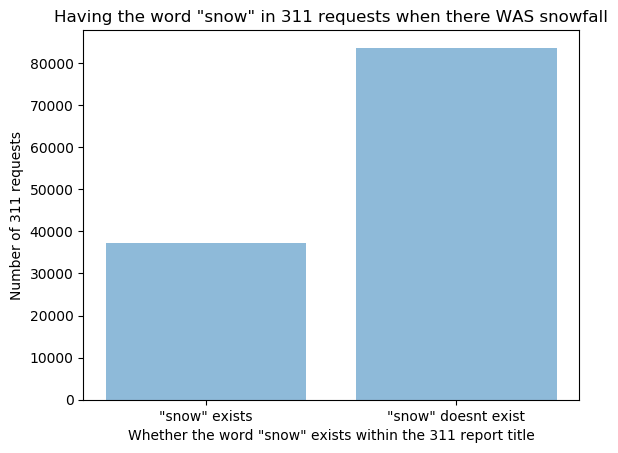

In [27]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
x_pos = ('"snow" exists', '"snow" doesnt exist')
y_pos = np.arange(len(x_pos))
performance = [count_yes,count_noSnowReport]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x_pos)
plt.ylabel('Number of 311 requests')
plt.xlabel('Whether the word "snow" exists within the 311 report title')
plt.title('Having the word "snow" in 311 requests when there WAS snowfall')
 
plt.show()

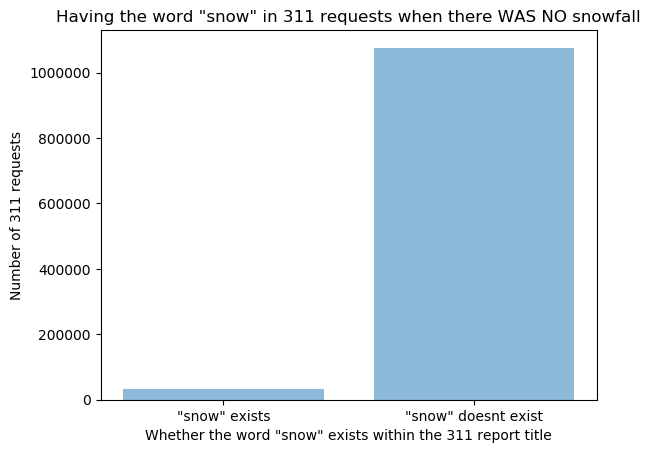

In [28]:
x_pos = ('"snow" exists', '"snow" doesnt exist')
y_pos = np.arange(len(x_pos))
performance = [count_no,count_noSnownoReport]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x_pos)
plt.ylabel('Number of 311 requests')
plt.xlabel('Whether the word "snow" exists within the 311 report title')
plt.title('Having the word "snow" in 311 requests when there WAS NO snowfall')
 
plt.show()

### Winter 14-15:
    - More snow plow requests than other requests occur on days that have > 0.0 snowfall in inches
    - When there is no snow fall, most reports do not have the word snow
### Overall:
    - There are more non-snow plow requests on days that have > 0.0 snowfall
    - Almost no requests for snow plowing on days that have no snow

In [29]:
# Data manipulation: get counts of reports by neighborhood
value_counts = df["neighborhood"].value_counts()
value_counts

Dorchester                                181977
Roxbury                                   109818
Allston/Brighton                           93891
Back Bay/Beacon Hill                       84319
Jamaica Plain                              83393
South Boston / South Boston Waterfront     80828
Downtown / Financial District              71991
East Boston                                66998
West Roxbury                               60735
Hyde Park                                  59040
Greater Mattapan                           58183
South End                                  54848
Roslindale                                 52780
                                           44500
Charlestown                                37064
Boston                                     29217
Fenway/Kenmore                             26934
Mission Hill                               21978
South Boston                                7129
Mattapan                                    1685
Chestnut Hill       

In [31]:
# df[has_snow].filter(['Year', 'Month', 'Day', 'days_since_last_snow']).groupby(by=['Year', 'Month', 'Day']).groupby(by='days_since_last_snow').count()

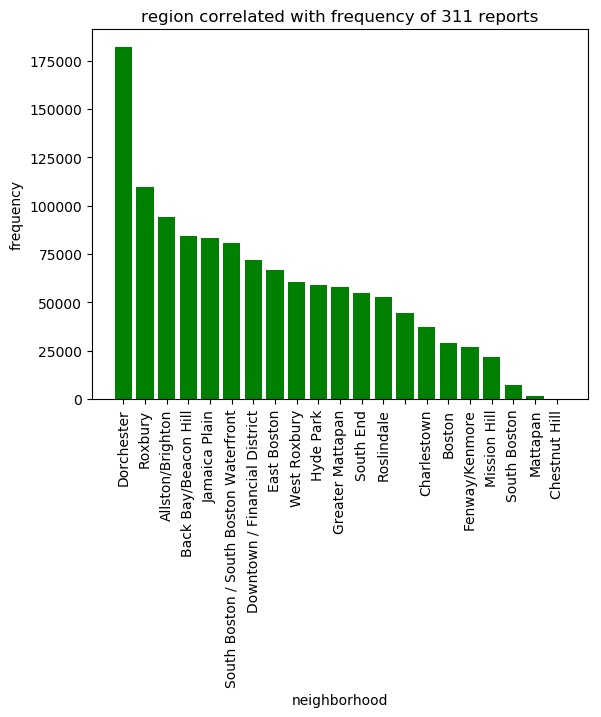

In [32]:
x_pos = np.arange(len(value_counts.keys()))
plt.bar(x_pos, list(value_counts[key] for key in value_counts.keys()), align='center',
        color='green', ecolor='black')
plt.xticks(x_pos, value_counts.keys(), rotation='vertical')
plt.xlabel("neighborhood")
plt.ylabel("frequency")
plt.title("region correlated with frequency of 311 reports")
plt.show()

[Boston population by neighborhood](https://statisticalatlas.com/place/Massachusetts/Boston/Population#figure/neighborhood/total-population)

In [37]:
# Data manipulation: get counts of reports by region
value_counts = df["median household income"].value_counts()
value_counts

45807    181977
30654    109818
52362     93891
82742     84319
55861     83393
43511     66998
71066     60735
53474     59040
51870     54848
62702     52780
83926     37064
52433     29217
32509     26934
63747      7129
42164      1685
Name: median household income, dtype: int64

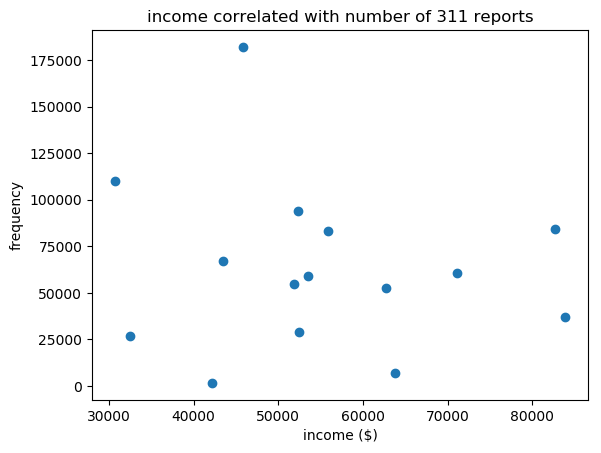

In [38]:
# Plot how many of our reports come from low vs high income areas
plt.scatter(list(map(lambda x: int(x), value_counts.keys())), list(value_counts[key] for key in value_counts.keys()))
plt.xlabel("income ($)")
plt.ylabel("frequency")
plt.title("income correlated with number of 311 reports")
plt.show()

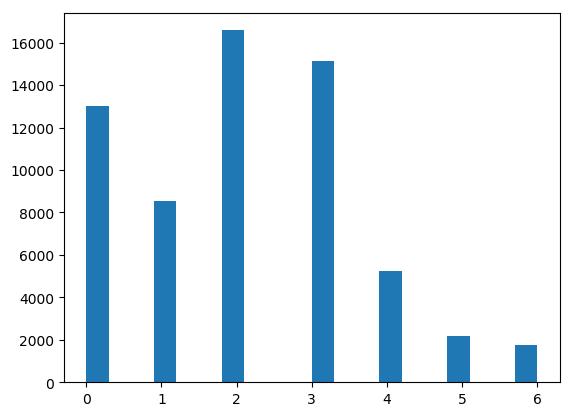

In [39]:
pd.set_option('display.max_columns', None)
plt.hist(df['consecutive_snow_days'][df['type'] == 'Request for Snow Plowing'], bins=20)

plt.show()

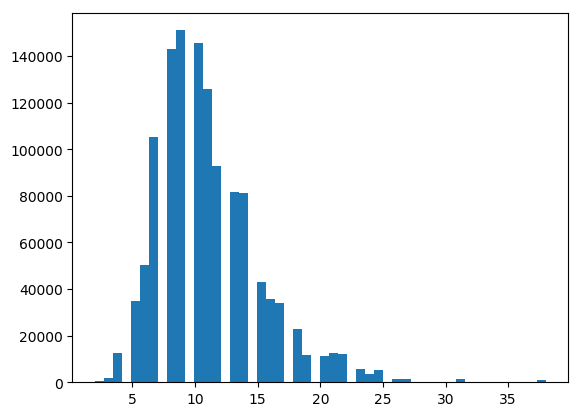

In [46]:
# Data manipulation: Put snowfall into bins
plt.hist(df['High Wind Gust (mph)'], bins=50)

plt.show()

In [52]:
df[df['High Wind Gust (mph)'] > 100]['case_title']

60571                                Highway Maintenance
60572                          Tree Maintenance Requests
60573                       Pavement Marking Maintenance
60574                        Sidewalk Repair (Make Safe)
60575                                Pick up Dead Animal
60576                        Sidewalk Repair (Make Safe)
60577                                Pick up Dead Animal
60578                                Highway Maintenance
60579                                Highway Maintenance
60580                                       Missing Sign
60581                                    Sticker Request
60582                                   Graffiti Removal
60583                                    Sticker Request
60584                         Request for Pothole Repair
60585                                Highway Maintenance
60586                              Traffic Signal Repair
60587                                Pick up Dead Animal
60588                          

- Not sure how to normalize our data
- Snow has a delayed effect - requests related to snow can happen the day after it snows

In [94]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def make_wordcloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'white',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (20, 15),
        facecolor = 'white',
        edgecolor = 'white')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Windy

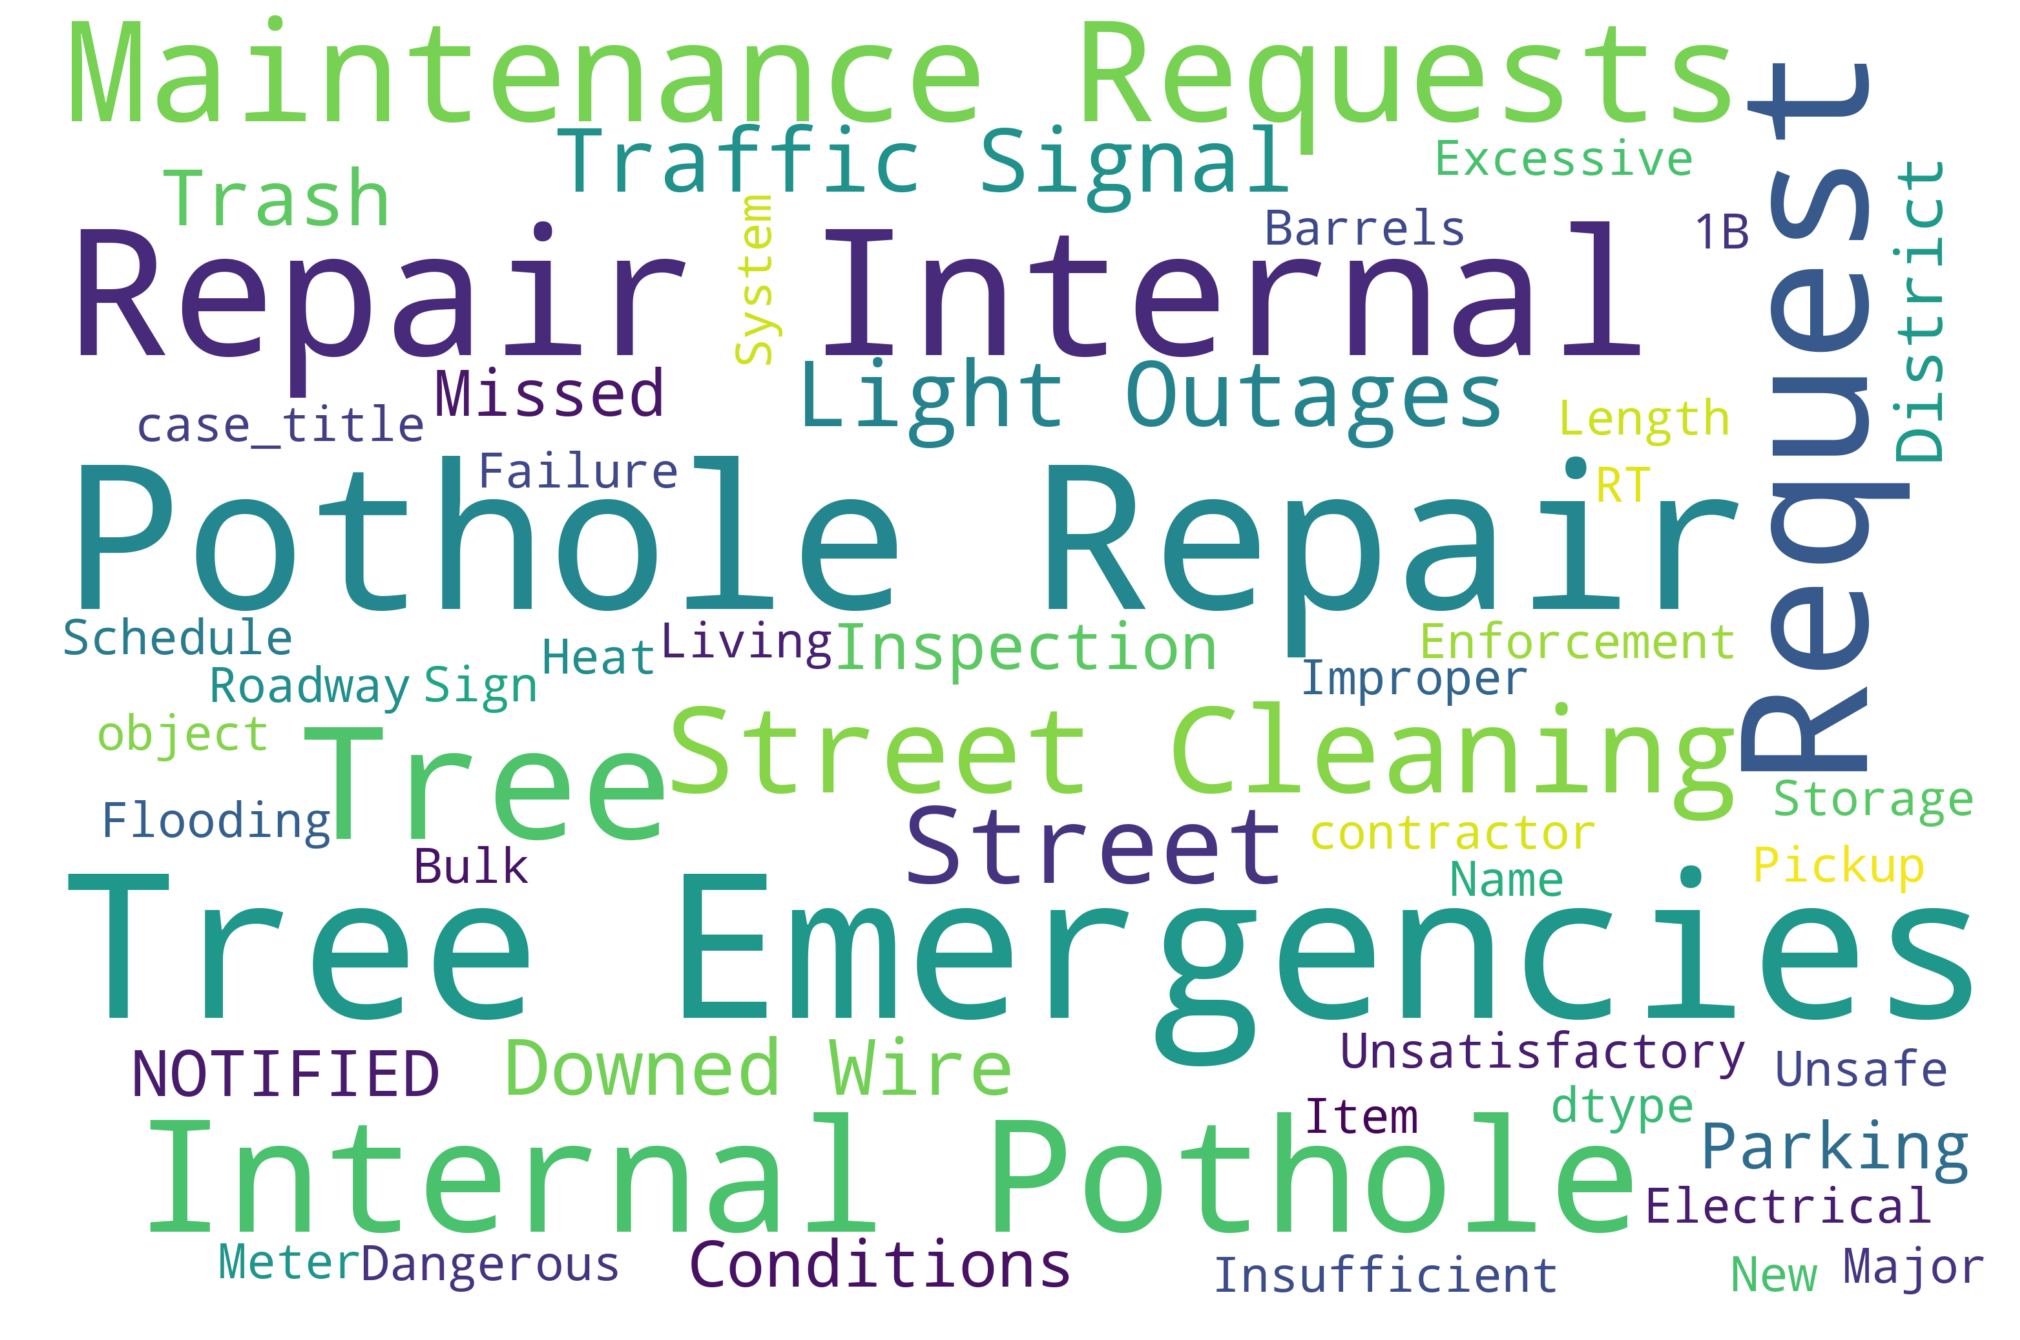

In [95]:
make_wordcloud(df[df['Avg Wind (mph)'] > 30]['case_title'])

# Snowy

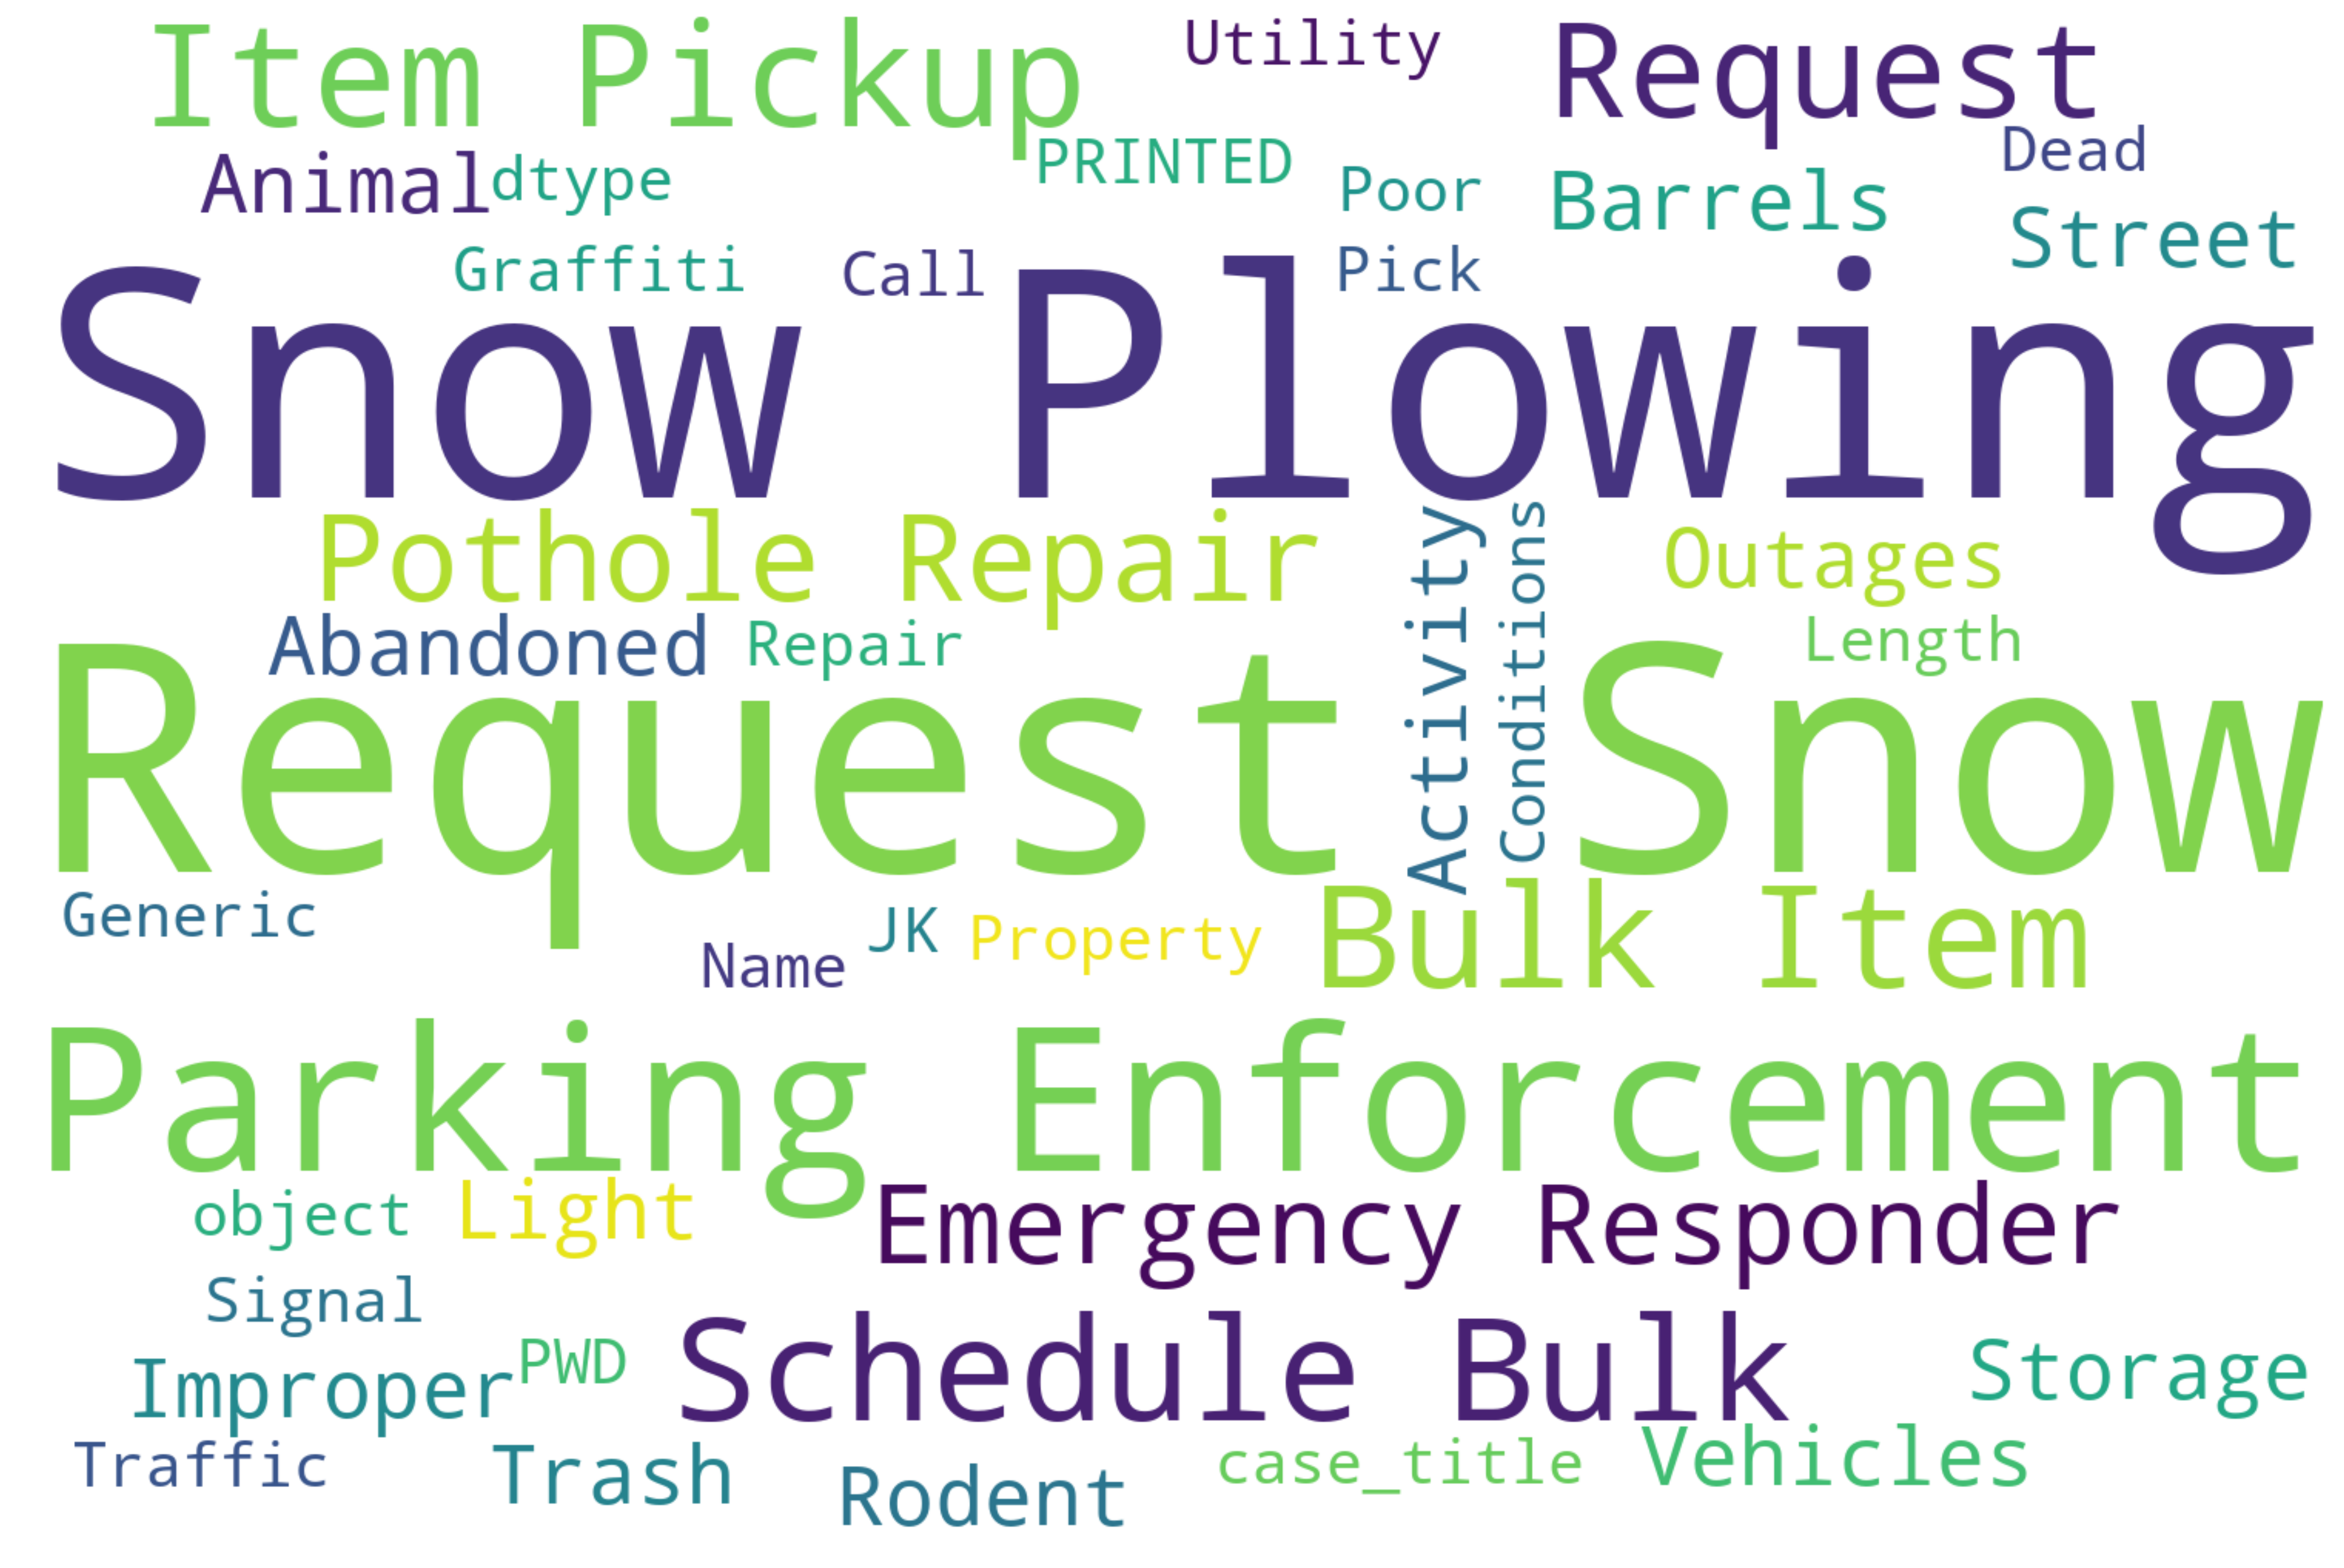

In [91]:
make_wordcloud(df[df['days_since_last_snow'] < 3]['case_title'])

# Chilly

In [92]:
celcius = df['Low Temp (F)'].apply(lambda x: (x - 32) * (5.0/9.0))

Correlate 311 with demographics (income, race, etc)

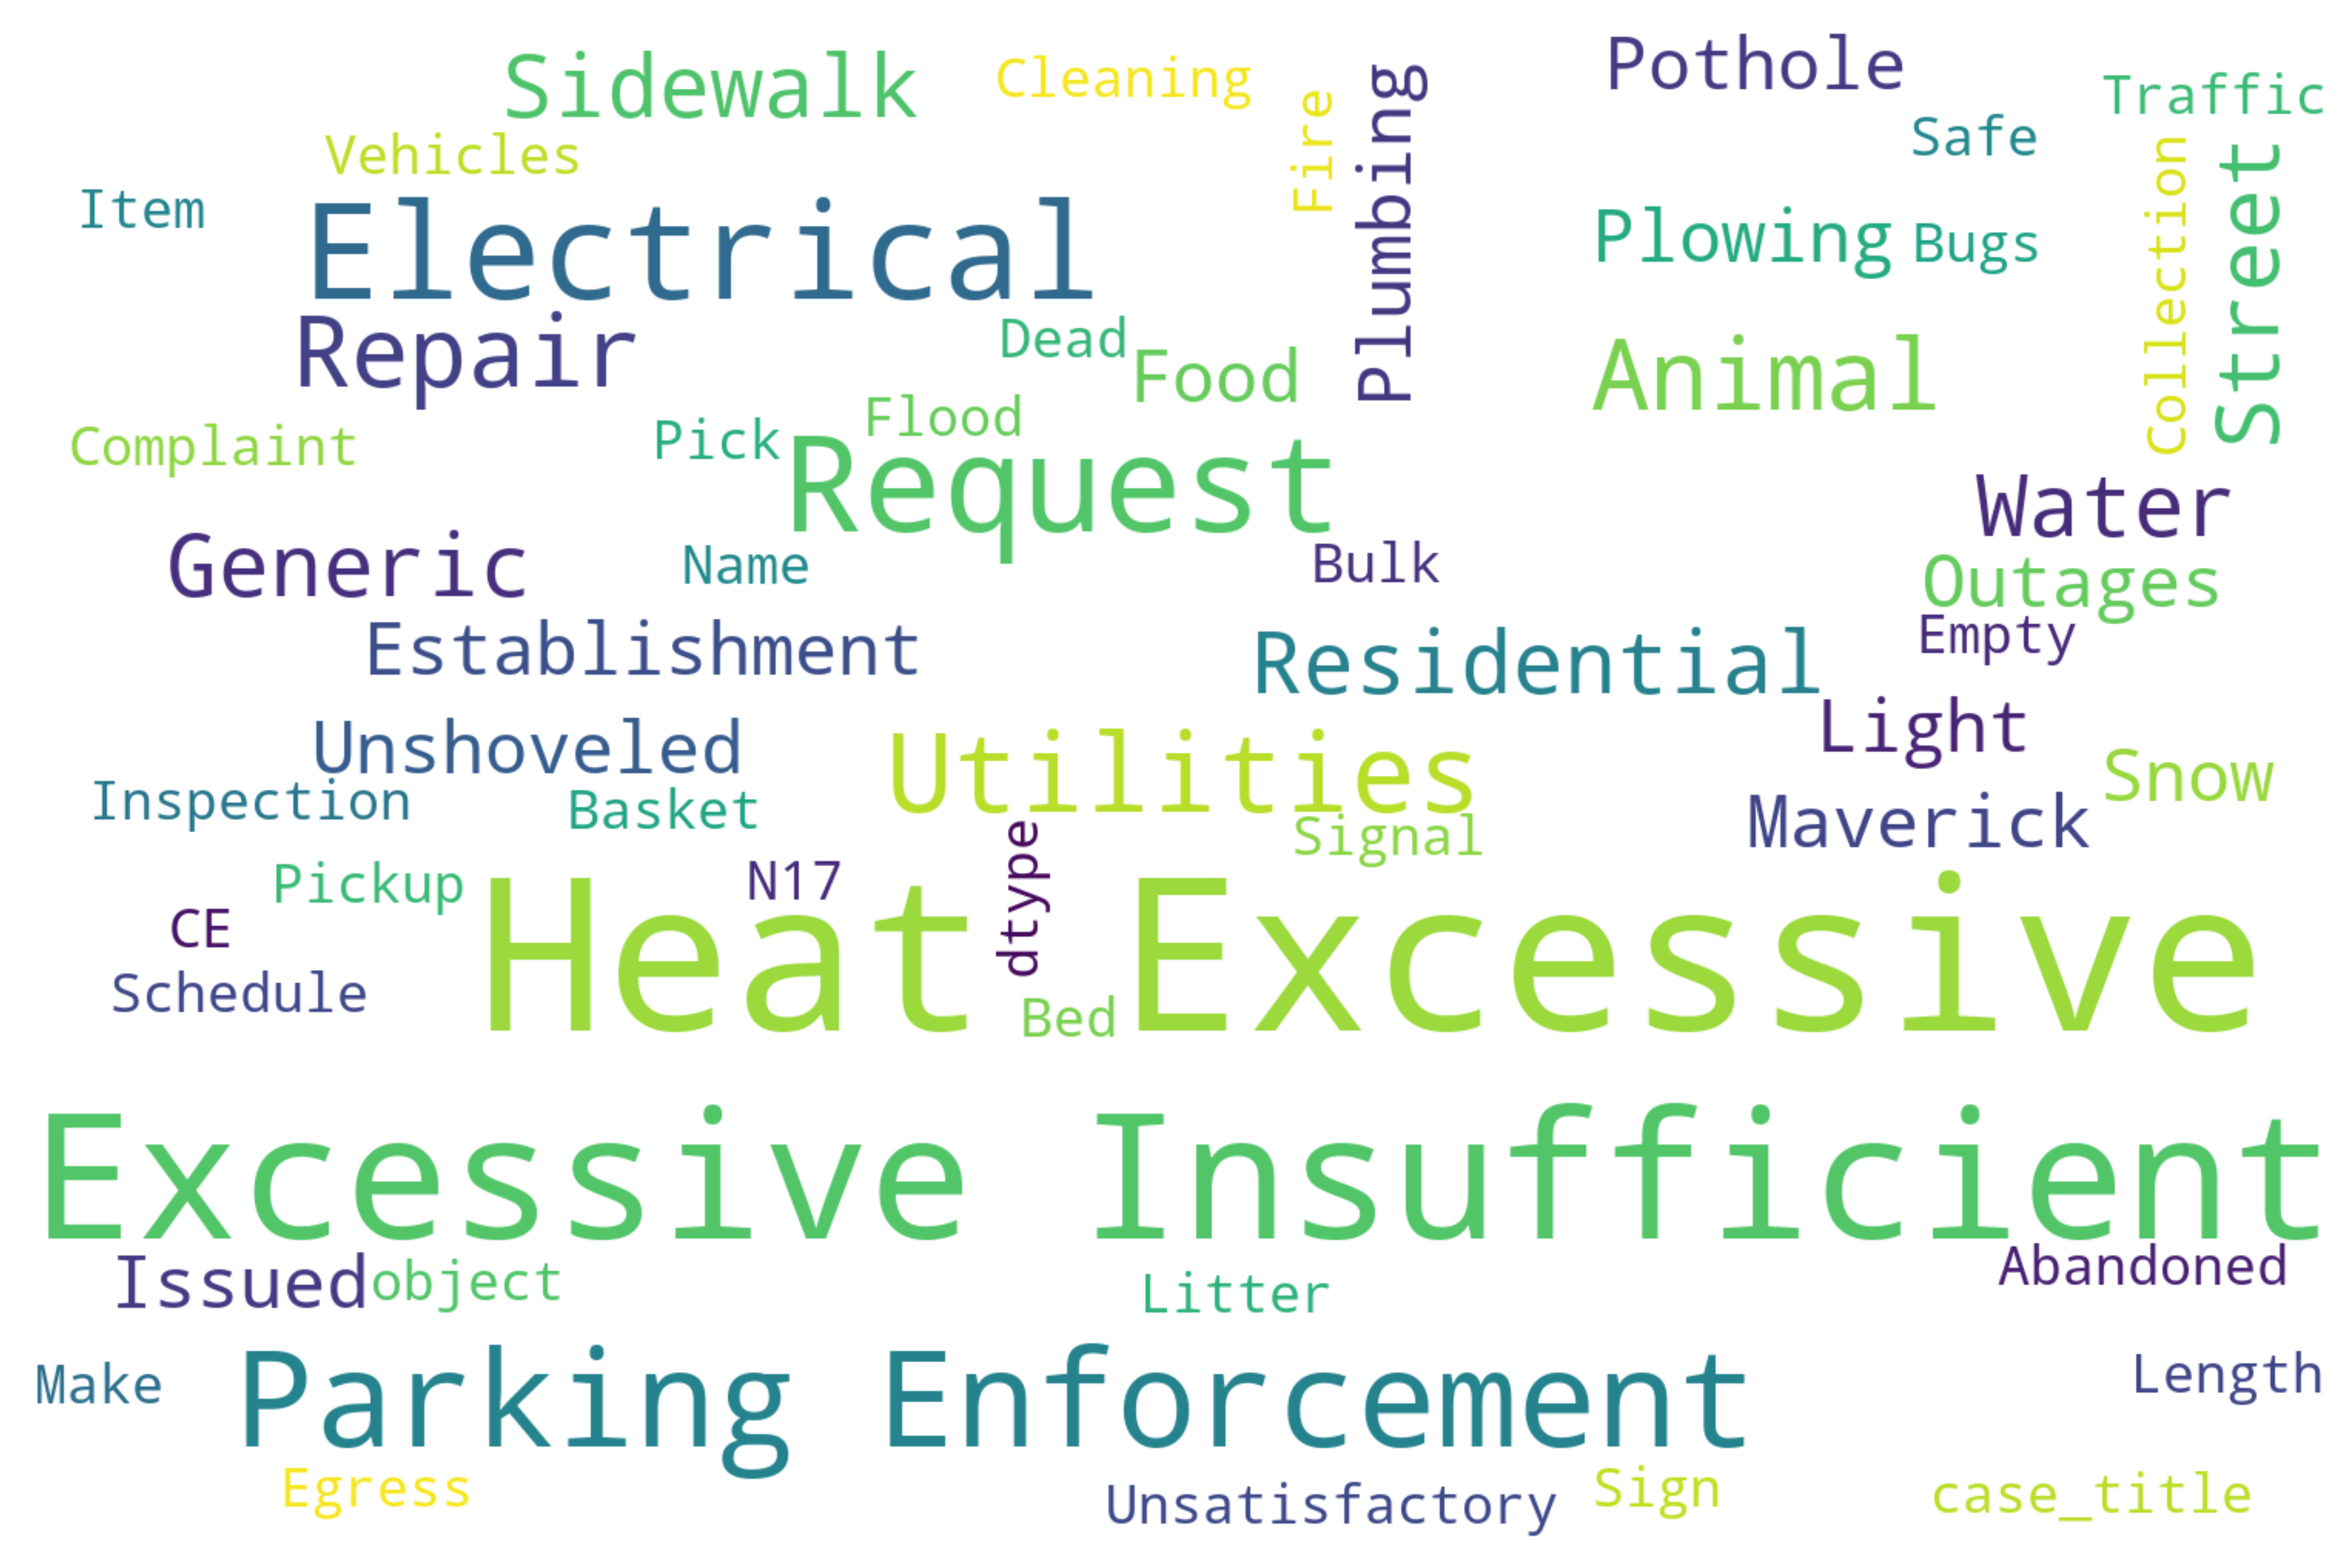

In [93]:
make_wordcloud(df[celcius < (-20)]['case_title'])

correlate region with frequency of 311 reports
correlate income with frequency of 311 reports

correlate weather with type of 311 report
correlate weather with number of 311 reports on that day



1. Make visualizations (individually) using our merged dataset
2. Look at those visualizations and come up with more questions to ask about the data


3. Merge demographics dataset into current dataset


## Conclusion